In [9]:
import pandas as pd
import matplotlib.pyplot as plt

In [11]:
df = pd.read_csv('2018-2022.csv')
df = df.drop(['Unnamed: 0'], axis=1)
df.head(5)

In [48]:
import folium
from folium import plugins
import osmnx as ox
import networkx as nx
import shapely
import geopandas as gpd
from shapely.geometry import CAP_STYLE, JOIN_STYLE, LineString
import numpy as np
import pickle
from geopy.geocoders import Nominatim
from shapely import geometry
from flask import Flask


In [15]:
#to simplify just select crime coords ...gotta swap Lat and long here
crimes=list(zip(df['LONGITUDE'].dropna(), df['LATITUDE'].dropna()))

with open('crimes_data', 'wb') as fp:
    pickle.dump(crimes, fp)

In [ ]:
with open ('crimes_data', 'rb') as fp:
    crimes = pickle.load(fp)

In [41]:
user_origin = "692 N Robertson Blvd, West Hollywood, CA 90069"
user_destination = "7871 Santa Monica Blvd, West Hollywood, CA 90046"

In [42]:
#get address mockup
def address_to_longlat(address):     
    geolocator = Nominatim(user_agent="decomposition.of.life@gmail.com")
    location = geolocator.geocode(address)
    return location.longitude, location.latitude


orig_long, orig_lat = address_to_longlat(user_origin)
dest_long, dest_lat = address_to_longlat(user_destination)
#origin


In [46]:
#create route
ox.config.log_console=True
ox.config.use_cache=True
G_walk = ox.graph_from_place('West Hollywood, Los Angeles County, California, United States',
                             network_type='walk')

orig_node = ox.distance.nearest_nodes(G_walk,orig_long, orig_lat)
dest_node = ox.distance.nearest_nodes(G_walk, dest_long, dest_lat)

route = nx.shortest_path(G_walk, #returns a sequence of nodes
                         orig_node,
                         dest_node,
                         weight='length')

In [44]:

#build map with route
m_dt = folium.Map(location=[34.09,-118.36], zoom_start=14)
route_map = ox.plot_route_folium(G_walk, route, m_dt)
#route_map.save('route.html')

In [65]:
#all graph nodes in the area (west hollywood)
graph_nodes = ox.graph_to_gdfs(G_walk, nodes=True, edges=False)

#obtain series of coordinates from a single route (list of nodes) - gives geopandas series
route_coord = graph_nodes.query('index in @route')['geometry']

#convert list of nodes into a GPD dataframe and join to route_coordinates to maintain correct index(node) order
nodes_gpd = gpd.GeoDataFrame(index=route)
route_geo = nodes_gpd.join(route_coord)

#setting for polygon geometry
CAP_STYLE.round
JOIN_STYLE.round

#create linestring object (compatible with shapely) from route coordinates
route_line = LineString( [[a.x, a.y] for a in route_geo['geometry']] )
#route_coord
route_line

In [67]:
sleeve = route_line.buffer(0.0005)

#plot the sleeve on map
folium.GeoJson(sleeve).add_to(m_dt)
m_dt

In [151]:
#count crimes in the selected area
def compute_route_crimes(sleeve):
    count = 0

    for loc in crimes:
        pt = geometry.Point(loc)
        if sleeve.contains(pt):
            count += 1

    return count

compute_route_crimes(sleeve)

378

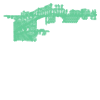

In [39]:
x = LineString()
for g in linestrings:
    x = LineString.union(x, g)

x

#if we take every edge in the area, its weight can be computed as num of crimes around it

In [51]:
#G = ox.graph_from_bbox( 34.091, 34.095, -118.381, -118.368, network_type='walk')
edges_gdf = ox.graph_to_gdfs(G_walk, nodes=False, edges=True)
edges_gdf = edges_gdf[['osmid', 'length', 'geometry']]

In [98]:
geometry = edges_gdf['geometry'].values[1]
test = list(geometry.coords)

In [99]:
test

[(-118.3727224, 34.0952298),
 (-118.3728251, 34.0952055),
 (-118.3731327, 34.0951333),
 (-118.3735928, 34.0950309)]

In [54]:
crimes_loc = [geometry.Point(loc) for loc in crimes]

def CrimeLevel(geometry):
    edge_line = LineString(geometry)
    sleeve = edge_line.buffer(0.0005)
    
    count = 0
    for pt in crimes_loc:
        if sleeve.contains(pt):
            count += 1
    
    return count

edges_gdf['weight'] = edges_gdf['geometry'].apply(CrimeLevel)
test_gdf = edges_gdf.droplevel('key')
test_gdf = test_gdf.set_index(['weight'], append=True)

edges_weights = list(test_gdf.index) #get list of edges weights that can be added

In [101]:
edges_gdf

osmid  length  \
u           v           key                                              
21569378    4341855726  0                            185720604  33.594   
            5167064044  0               [398790803, 400020966]  83.145   
21569384    2614048061  0                [526747217, 13430661]  46.491   
            123041372   0    [398794498, 400020548, 398794500]  99.503   
            8749647667  0                            398794501  20.278   
...                                                        ...     ...   
9960862753  9960862753  1             [1087134834, 1087134835]  80.074   
10002019097 7601828882  0                            518281395  44.439   
            10002019098 0                           1092108771  37.784   
            122633416   0                            518281395  59.757   
10002019098 10002019097 0                           1092108771  37.784   

                                                                      geometry  \
u           v           key                                                      
21569378    4341855726  0    LINESTRING (-118.37272 34.09523, -118.37247 34...   
            5167064044  0    LINESTRING (-118.37272 34.09523, -118.37283 34...   
21569384    2614048061  0    LINESTRING (-118.38554 34.09064, -118.38554 34...   
            123041372   0    LINESTRING (-118.38554 34.09064, -118.38543 34...   
            8749647667  0    LINESTRING (-118.38554 34.09064, -118.38565 34...   
...                                                                        ...   
9960862753  9960862753  1    LINESTRING (-118.37368 34.09444, -118.37342 34...   
10002019097 7601828882  0    LINESTRING (-118.35916 34.09136, -118.35917 34...   
            10002019098 0    LINESTRING (-118.35916 34.09136, -118.35957 34...   
            122633416   0    LINESTRING (-118.35916 34.09136, -118.35916 34...   
10002019098 10002019097 0    LINESTRING (-118.35957 34.09136, -118.35916 34...   

                             weight  
u           v           key          
21569378    4341855726  0        42  
            5167064044  0        51  
21569384    2614048061  0         1  
            123041372   0        26  
            8749647667  0         1  
...                             ...  
9960862753  9960862753  1         0  
10002019097 7601828882  0        59  
            10002019098 0        17  
            122633416   0        17  
10002019098 10002019097 0        17  

[2938 rows x 4 columns]

In [ ]:
# in progress - trying to set up a combined length+crime weighting coefficient for the edges
def CrimeLengthLevel(edges_gdf):
    edge_line = LineString(edges_gdf['geometry'])
    sleeve = edge_line.buffer(0.0005)

    edge_length = edges_gdf['length']
    
    count = 0
    for pt in crimes_loc:
        if sleeve.contains(pt):
            count += 1
    
    return count

edges_gdf['weight_length'] = edges_gdf.apply(CrimeLevel, axis=0)
test_gdf = edges_gdf.droplevel('key')
test_gdf = test_gdf.set_index(['weight_length'], append=True)

edges_weights_length = list(test_gdf.index) #get list of edges weights that can be added

In [55]:
edges_gdf['weight'] = edges_gdf['geometry'].apply(CrimeLevel)

In [62]:
test_gdf = edges_gdf.droplevel('key')
test_gdf = test_gdf.set_index(['weight'], append=True)

In [71]:
edges_weights_crime = list(test_gdf.index)

with open('edges_weights_crime', 'wb') as fp:
    pickle.dump(edges_weights_crime, fp)



In [97]:
ox.config.log_console=True
ox.config.use_cache=True

G_walk = ox.graph_from_place('West Hollywood, Los Angeles County, California, United States',
                             network_type='walk')

G_walk.add_weighted_edges_from(edges_weights_crime, 'weight')


In [92]:
#create graph with weighted edges
orig_node = ox.distance.nearest_nodes(G_walk,orig_long, orig_lat)
dest_node = ox.distance.nearest_nodes(G_walk, dest_long, dest_lat)


route2 = nx.shortest_path(G_walk, #returns a sequence of nodes
                         orig_node,
                         dest_node,
                         weight='weight')
#create a map
m_dt = folium.Map(location=[34.09,-118.36], zoom_start=14)

#add route to map
route_map = ox.plot_route_folium(G_walk, route2, m_dt)

In [94]:
((ox.utils_graph.get_route_edge_attributes(G_walk, route2)))


[{'osmid': [778158510, 381468534],
  'oneway': False,
  'lanes': '2',
  'name': 'North Robertson Boulevard',
  'highway': 'tertiary',
  'maxspeed': '30 mph',
  'reversed': False,
  'length': 49.122,
  'geometry': <shapely.geometry.linestring.LineString at 0x187ff1240>},
 {'osmid': [332803897, 397535604],
  'oneway': False,
  'lanes': ['3', '2'],
  'ref': 'CA 2',
  'name': 'Santa Monica Boulevard',
  'highway': 'primary',
  'maxspeed': '35 mph',
  'reversed': False,
  'length': 115.519,
  'geometry': <shapely.geometry.linestring.LineString at 0x187292710>},
 {'osmid': 332803897,
  'oneway': False,
  'lanes': '3',
  'ref': 'CA 2',
  'name': 'Santa Monica Boulevard',
  'highway': 'primary',
  'maxspeed': '35 mph',
  'reversed': False,
  'length': 44.506},
 {'osmid': 332803897,
  'oneway': False,
  'lanes': '3',
  'ref': 'CA 2',
  'name': 'Santa Monica Boulevard',
  'highway': 'primary',
  'maxspeed': '35 mph',
  'reversed': False,
  'length': 20.086},
 {'osmid': 1054937333,
  'oneway': Fa

In [76]:
length = int(sum(ox.utils_graph.get_route_edge_attributes(G_walk, route, "length")))
length

2573

In [77]:
length = int(sum(ox.utils_graph.get_route_edge_attributes(G_walk, route2, "length")))
length

3729

In [78]:
weight = int(sum(ox.utils_graph.get_route_edge_attributes(G_walk, route2, attribute="weight")))

KeyError: 'weight'

In [ ]:
#plot crime points
m = folium.Map(location = [34.1, -118.4], tiles='OpenStreetMap')

for i in range(len(crimes)):
    folium.CircleMarker(location=crimes[i], radius=1, tooltip=crimes[i]).add_to(m)
m

In [ ]:
#plot clustered crimes
m = folium.Map(location = [34.1, -118.4], tiles='OpenStreetMap')


cluster = plugins.MarkerCluster(locations=crimes)  
m.add_child(cluster)